In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.visualization import make_lupton_rgb

import artpop

plt.style.use('jpg.mplstyle')
g_i_colors = np.loadtxt('/Users/jgreco/Desktop/artpop-dwarfs/g_i_colors.txt')[:, 1]

In [2]:
pkl_fn = lambda i: f'/Users/jgreco/Desktop/artpop-dwarfs/ssp-{i}.pkl'

idx_red = g_i_colors.argmax()
idx_blue = g_i_colors.argmin()
idx_med = np.abs(g_i_colors - np.median(g_i_colors)).argmin()

ssp_red = artpop.MISTSSP.from_pickle(pkl_fn(idx_red))
ssp_med = artpop.MISTSSP.from_pickle(pkl_fn(idx_med))
ssp_blue = artpop.MISTSSP.from_pickle(pkl_fn(idx_blue))

In [3]:
pixel_scale = 0.263
distance = 2.5 * u.Mpc

struct_kw = dict(
    n = 1.0,
    r_eff = 150 * u.pc,
    ellip = 0.3,
    theta = 135,
    xy_dim = 351,
    pixel_scale = pixel_scale,
)

ssp_red.set_distance(distance)
ssp_med.set_distance(distance)
ssp_blue.set_distance(distance)

src_red = artpop.SersicSP(ssp_red, **struct_kw)
src_med = artpop.SersicSP(ssp_med, **struct_kw)
src_blue = artpop.SersicSP(ssp_blue, **struct_kw)

In [4]:
imager = artpop.ArtImager('DECam', diameter=4*u.m)
mu_sky_vals = [19.9, 21.2, 22.0] # sky brightness
exptimes = np.array([2, 1, 1]) * u.hr # exposure times

In [5]:
Q = 8
stretch = 0.18
fwhm = dict(i=0.97, r=1.07, g=1.25)

psf = {b: artpop.moffat_psf(fwhm[b], pixel_scale, 61) for b in 'gri'}

colors = ['blue', 'med', 'red']


src = src_red
src_dict = dict(blue=src_blue, med=src_med, red=src_red)

rgb = dict()

for c in colors:
    images = []
    # mock observe in gri
    for num, band in enumerate('irg'):
        obs = imager.observe(
            src_dict[c], f'DECam_{band}', exptimes[num], psf=psf[band],
            sky_sb=mu_sky_vals[num]
        )
        images.append(obs.image)
    # create RGB image
    rgb[c] = make_lupton_rgb(*images, stretch=stretch, Q=Q)

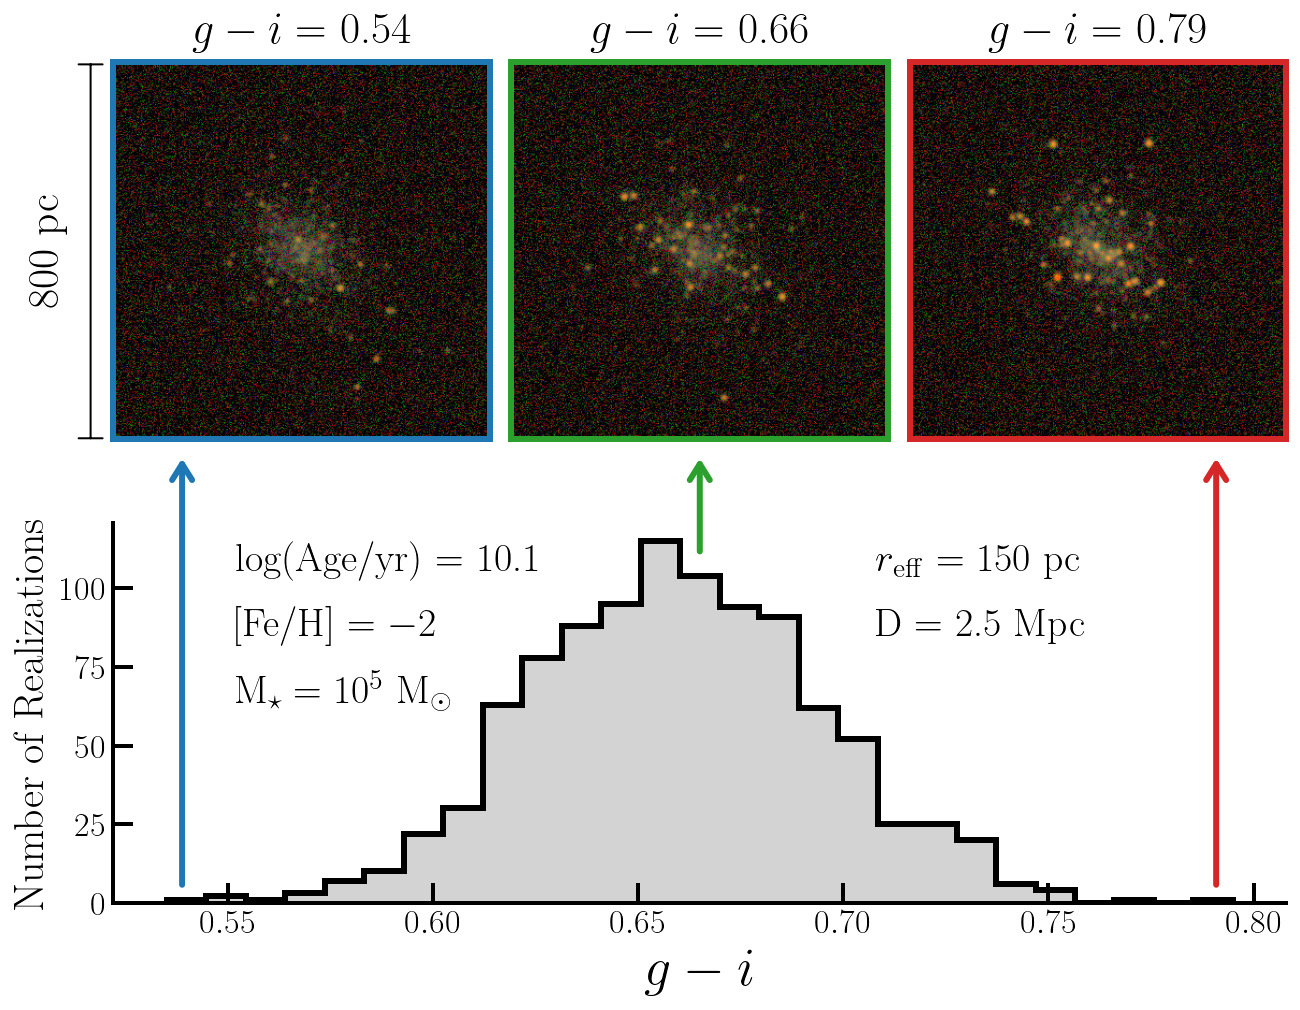

In [6]:
axes = plt.figure(figsize=(9.5, 7), tight_layout=True).subplot_mosaic(
    """
    ABC
    DDD
    """
)

fs = 22

for a, c in zip('ABC', colors):
    axes[a].set(xticks=[], yticks=[], aspect='equal')
    artpop.show_image(rgb[c], subplots=(None, axes[a]));
    
    gi = src_dict[c].sp.integrated_color('DECam_g', 'DECam_i')
    axes[a].set_title(f'$g-i$ = {gi:.2f}', fontsize=fs, y=1.015)

    
axes['A'].set_ylabel('800 pc', fontsize=fs, labelpad=23)
axes['A'].annotate('', xy=( -0.06, -0.009), xytext=(-0.06, 1.005), xycoords='axes fraction',
                  arrowprops=dict(facecolor='black',  arrowstyle='|-|,widthA=0.6,widthB=0.6'))


_, bins, _ = axes['D'].hist(g_i_colors, bins='auto', color='lightgrey', range=[0.535, 0.795])
axes['D'].hist(g_i_colors, bins='auto', color='k', histtype='step', lw=3., range=[0.535, 0.795])


axes['D'].set_ylabel('Number of Realizations', fontsize=fs-1)
axes['D'].set_xlabel('$g-i$', fontsize=fs+5)
    
axes['D'].tick_params(labelsize=fs-5)


fs = 20
y = 0.9
dy = 0.17
dx = 0.3
ha = 'left'


kw = dict(transform=axes['D'].transAxes, 
           fontsize=fs, ha=ha, va='center')
x = 0.105


axes['D'].text(x, y, 'log(Age/yr) = 10.1', **kw)
axes['D'].text(x, y - dy, '[Fe/H] = $-2$', **kw)
axes['D'].text(x, y - 2 * dy, r'M$_\star = 10^5$ M$_\odot$', **kw);



x = 0.65
axes['D'].text(x, y, '$r_\mathrm{eff}$ = 150 pc', **kw)
axes['D'].text(x, y - dy, f'D = 2.5 Mpc', **kw)



axes['D'].spines['right'].set_visible(False)
axes['D'].spines['top'].set_visible(False)
axes['D'].yaxis.set_ticks_position('left')
axes['D'].xaxis.set_ticks_position('bottom')



axes['D'].annotate("",
            xy=(0.935, 0.55), xycoords='figure fraction',
            xytext=(0.935, 0.12), textcoords='figure fraction', 
            arrowprops=dict(arrowstyle="->,head_length=0.8,head_width=0.5",
                            connectionstyle="arc3", lw=3, color='tab:red'))

for s in ['left', 'right', 'bottom', 'top']:
    axes['C'].spines[s].set_color('tab:red')
    axes['C'].spines[s].set_linewidth(3)
    
axes['D'].annotate("",
            xy=(0.14, 0.55), xycoords='figure fraction',
            xytext=(0.14, 0.12), textcoords='figure fraction', 
            arrowprops=dict(arrowstyle="->,head_length=0.8,head_width=0.5",
                            connectionstyle="arc3", lw=3, color='tab:blue'))


for s in ['left', 'right', 'bottom', 'top']:
    axes['A'].spines[s].set_color('tab:blue')
    axes['A'].spines[s].set_linewidth(3)



axes['D'].annotate("",
            xy=(0.538, 0.55), xycoords='figure fraction',
            xytext=(0.538, 0.45), textcoords='figure fraction', 
            arrowprops=dict(arrowstyle="->,head_length=0.8,head_width=0.5",
                            connectionstyle="arc3", lw=3, color='tab:green'))


for s in ['left', 'right', 'bottom', 'top']:
    axes['B'].spines[s].set_color('tab:green')
    axes['B'].spines[s].set_linewidth(3)